## Classifying Bad Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [7]:
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


### Set network parameters

In [8]:
# Dataset/Featurization Config
path = '/u/74/surikua1/unix/Downloads/full_cols_bad_50k.csv'
label = 'bad'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisbad_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/gru/model_' + run_name + '.ckpt'
should_log_metrics = True

In [9]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [10]:
%%time
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

CPU times: user 8.25 s, sys: 20 ms, total: 8.27 s
Wall time: 8.23 s


### Configure dataset

In [11]:
%%time
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at /u/74/surikua1/unix/Downloads/full_cols_bad_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.
CPU times: user 11min 15s, sys: 54 s, total: 12min 9s
Wall time: 6min 15s


### Prepare model configurations

In [12]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [13]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [14]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [15]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/u/74/surikua1/unix/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Train model

In [17]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.696716, Training Accuracy= 0.33333
Iter 300, Minibatch Loss= 0.715113, Training Accuracy= 0.53333
Iter 450, Minibatch Loss= 0.667222, Training Accuracy= 0.66667
Iter 600, Minibatch Loss= 0.639930, Training Accuracy= 0.66667
Iter 750, Minibatch Loss= 0.670442, Training Accuracy= 0.60000
Validation Accuracy: 0.64552
Validation Loss: 0.6565766


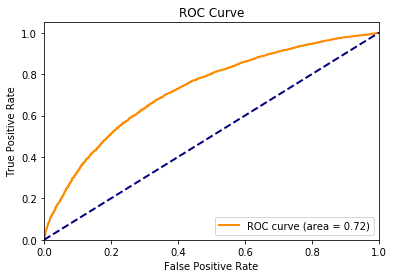

Iter 900, Minibatch Loss= 0.642880, Training Accuracy= 0.66667
Iter 1050, Minibatch Loss= 0.627715, Training Accuracy= 0.66667
Iter 1200, Minibatch Loss= 0.626203, Training Accuracy= 0.80000
Iter 1350, Minibatch Loss= 0.628166, Training Accuracy= 0.53333
Iter 1500, Minibatch Loss= 0.740652, Training Accuracy= 0.66667
Validation Accuracy: 0.6672799
Validation Loss: 0.64220583


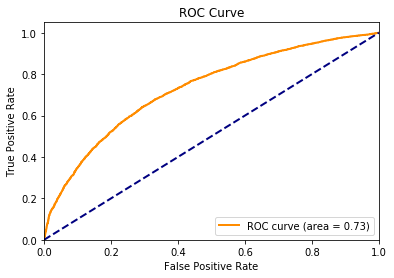

Iter 1650, Minibatch Loss= 0.690433, Training Accuracy= 0.60000
Iter 1800, Minibatch Loss= 0.637821, Training Accuracy= 0.86667
Iter 1950, Minibatch Loss= 0.493682, Training Accuracy= 0.86667
Iter 2100, Minibatch Loss= 0.551771, Training Accuracy= 0.80000
Iter 2250, Minibatch Loss= 0.603072, Training Accuracy= 0.80000
Validation Accuracy: 0.66983986
Validation Loss: 0.62832975


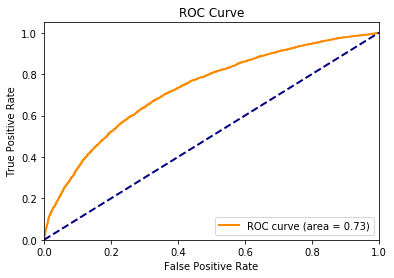

Iter 2400, Minibatch Loss= 0.685202, Training Accuracy= 0.53333
Iter 2550, Minibatch Loss= 0.646268, Training Accuracy= 0.60000
Iter 2700, Minibatch Loss= 0.709477, Training Accuracy= 0.60000
Iter 2850, Minibatch Loss= 0.541255, Training Accuracy= 0.66667
Iter 3000, Minibatch Loss= 0.677205, Training Accuracy= 0.53333
Validation Accuracy: 0.6575999
Validation Loss: 0.6219917
Iter 3150, Minibatch Loss= 0.669782, Training Accuracy= 0.66667
Iter 3300, Minibatch Loss= 0.503233, Training Accuracy= 0.86667
Iter 3450, Minibatch Loss= 0.753054, Training Accuracy= 0.53333
Iter 3600, Minibatch Loss= 0.628162, Training Accuracy= 0.60000
Iter 3750, Minibatch Loss= 0.609283, Training Accuracy= 0.80000
Validation Accuracy: 0.67327994
Validation Loss: 0.627074


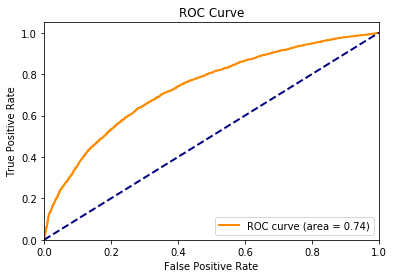

Iter 3900, Minibatch Loss= 0.625510, Training Accuracy= 0.60000
Iter 4050, Minibatch Loss= 0.567613, Training Accuracy= 0.73333
Iter 4200, Minibatch Loss= 0.645784, Training Accuracy= 0.66667
Iter 4350, Minibatch Loss= 0.556462, Training Accuracy= 0.86667
Iter 4500, Minibatch Loss= 0.616820, Training Accuracy= 0.66667
Validation Accuracy: 0.66511995
Validation Loss: 0.6140069
Iter 4650, Minibatch Loss= 0.599469, Training Accuracy= 0.73333
Iter 4800, Minibatch Loss= 0.587683, Training Accuracy= 0.60000
Iter 4950, Minibatch Loss= 0.633688, Training Accuracy= 0.60000
Iter 5100, Minibatch Loss= 0.568444, Training Accuracy= 0.73333
Iter 5250, Minibatch Loss= 0.515869, Training Accuracy= 0.80000
Validation Accuracy: 0.6813599
Validation Loss: 0.60890186


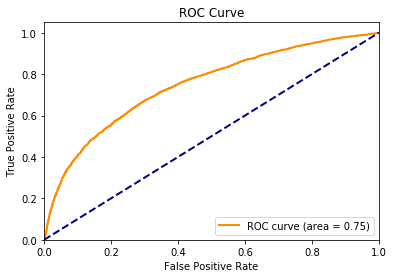

Iter 5400, Minibatch Loss= 0.574155, Training Accuracy= 0.73333
Iter 5550, Minibatch Loss= 0.666634, Training Accuracy= 0.53333
Iter 5700, Minibatch Loss= 0.632263, Training Accuracy= 0.73333
Iter 5850, Minibatch Loss= 0.589858, Training Accuracy= 0.80000
Iter 6000, Minibatch Loss= 0.790223, Training Accuracy= 0.40000
Validation Accuracy: 0.6842399
Validation Loss: 0.6079499


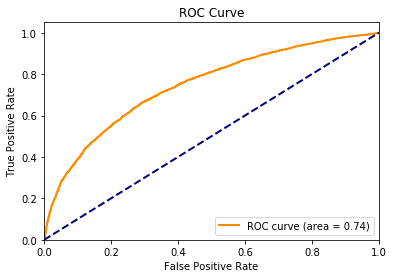

Iter 6150, Minibatch Loss= 0.615248, Training Accuracy= 0.60000
Iter 6300, Minibatch Loss= 0.801616, Training Accuracy= 0.46667
Iter 6450, Minibatch Loss= 0.590323, Training Accuracy= 0.53333
Iter 6600, Minibatch Loss= 0.605219, Training Accuracy= 0.60000
Iter 6750, Minibatch Loss= 0.612542, Training Accuracy= 0.60000
Validation Accuracy: 0.6863999
Validation Loss: 0.606811


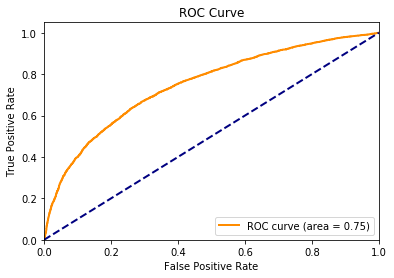

Iter 6900, Minibatch Loss= 0.624194, Training Accuracy= 0.80000
Iter 7050, Minibatch Loss= 0.518865, Training Accuracy= 0.80000
Iter 7200, Minibatch Loss= 0.637354, Training Accuracy= 0.66667
Iter 7350, Minibatch Loss= 0.529687, Training Accuracy= 0.66667
Iter 7500, Minibatch Loss= 0.554429, Training Accuracy= 0.66667
Validation Accuracy: 0.6872799
Validation Loss: 0.6034679


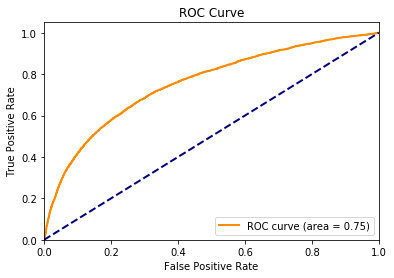

Iter 7650, Minibatch Loss= 0.560351, Training Accuracy= 0.80000
Iter 7800, Minibatch Loss= 0.459927, Training Accuracy= 0.86667
Iter 7950, Minibatch Loss= 0.848545, Training Accuracy= 0.40000
Iter 8100, Minibatch Loss= 0.623985, Training Accuracy= 0.53333
Iter 8250, Minibatch Loss= 0.575006, Training Accuracy= 0.73333
Validation Accuracy: 0.63192
Validation Loss: 0.6333383
Iter 8400, Minibatch Loss= 0.507297, Training Accuracy= 0.80000
Iter 8550, Minibatch Loss= 0.540213, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.928301, Training Accuracy= 0.60000
Iter 8850, Minibatch Loss= 0.507528, Training Accuracy= 0.80000
Iter 9000, Minibatch Loss= 0.762526, Training Accuracy= 0.53333
Validation Accuracy: 0.70503986
Validation Loss: 0.5908465


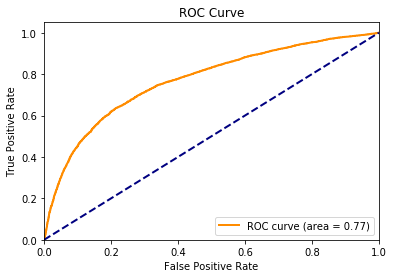

Iter 9150, Minibatch Loss= 0.562304, Training Accuracy= 0.80000
Iter 9300, Minibatch Loss= 0.515395, Training Accuracy= 0.73333
Iter 9450, Minibatch Loss= 0.512427, Training Accuracy= 0.93333
Iter 9600, Minibatch Loss= 0.378923, Training Accuracy= 0.86667
Iter 9750, Minibatch Loss= 0.518727, Training Accuracy= 0.73333
Validation Accuracy: 0.7130399
Validation Loss: 0.5863333


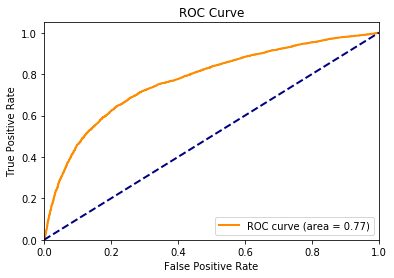

Iter 9900, Minibatch Loss= 0.581488, Training Accuracy= 0.73333
Iter 10050, Minibatch Loss= 0.395390, Training Accuracy= 0.86667
Iter 10200, Minibatch Loss= 0.586364, Training Accuracy= 0.73333
Iter 10350, Minibatch Loss= 0.452827, Training Accuracy= 0.86667
Iter 10500, Minibatch Loss= 0.597692, Training Accuracy= 0.73333
Validation Accuracy: 0.6949599
Validation Loss: 0.59007305
Iter 10650, Minibatch Loss= 0.405699, Training Accuracy= 0.93333
Iter 10800, Minibatch Loss= 0.409444, Training Accuracy= 0.80000
Iter 10950, Minibatch Loss= 0.765809, Training Accuracy= 0.46667
Iter 11100, Minibatch Loss= 0.713899, Training Accuracy= 0.46667
Iter 11250, Minibatch Loss= 0.470354, Training Accuracy= 0.73333
Validation Accuracy: 0.7071999
Validation Loss: 0.58454144
Iter 11400, Minibatch Loss= 0.588619, Training Accuracy= 0.80000
Iter 11550, Minibatch Loss= 1.811189, Training Accuracy= 0.66667
Iter 11700, Minibatch Loss= 0.451678, Training Accuracy= 0.86667
Iter 11850, Minibatch Loss= 0.590110, 

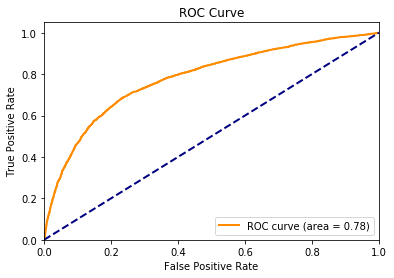

Iter 15150, Minibatch Loss= 0.505296, Training Accuracy= 0.86667
Iter 15300, Minibatch Loss= 0.393812, Training Accuracy= 0.86667
Iter 15450, Minibatch Loss= 0.557853, Training Accuracy= 0.80000
Iter 15600, Minibatch Loss= 0.463519, Training Accuracy= 0.93333
Iter 15750, Minibatch Loss= 0.614510, Training Accuracy= 0.66667
Validation Accuracy: 0.70247984
Validation Loss: 0.595138
Iter 15900, Minibatch Loss= 0.596760, Training Accuracy= 0.80000
Iter 16050, Minibatch Loss= 0.393964, Training Accuracy= 0.93333
Iter 16200, Minibatch Loss= 0.456793, Training Accuracy= 0.80000
Iter 16350, Minibatch Loss= 0.547179, Training Accuracy= 0.73333
Iter 16500, Minibatch Loss= 0.751393, Training Accuracy= 0.46667
Validation Accuracy: 0.5956
Validation Loss: 0.6531199
Iter 16650, Minibatch Loss= 0.762866, Training Accuracy= 0.53333
Iter 16800, Minibatch Loss= 0.634573, Training Accuracy= 0.60000
Iter 16950, Minibatch Loss= 0.709849, Training Accuracy= 0.66667
Iter 17100, Minibatch Loss= 0.515651, Trai

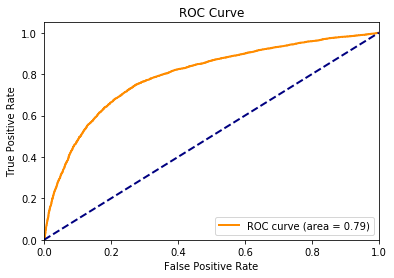

Iter 18900, Minibatch Loss= 0.541001, Training Accuracy= 0.73333
Iter 19050, Minibatch Loss= 0.398140, Training Accuracy= 0.86667
Iter 19200, Minibatch Loss= 0.714556, Training Accuracy= 0.46667
Iter 19350, Minibatch Loss= 0.508261, Training Accuracy= 0.93333
Iter 19500, Minibatch Loss= 0.561399, Training Accuracy= 0.66667
Validation Accuracy: 0.7029599
Validation Loss: 0.5755099
Iter 19650, Minibatch Loss= 0.492445, Training Accuracy= 0.80000
Iter 19800, Minibatch Loss= 0.570609, Training Accuracy= 0.73333
Iter 19950, Minibatch Loss= 0.521490, Training Accuracy= 0.66667
Iter 20100, Minibatch Loss= 0.697957, Training Accuracy= 0.60000
Iter 20250, Minibatch Loss= 0.786043, Training Accuracy= 0.73333
Validation Accuracy: 0.7407998
Validation Loss: 0.55105513


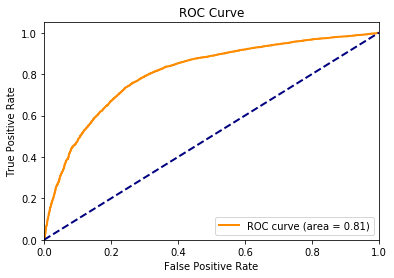

Iter 20400, Minibatch Loss= 0.516148, Training Accuracy= 0.80000
Iter 20550, Minibatch Loss= 0.509516, Training Accuracy= 0.73333
Iter 20700, Minibatch Loss= 0.447488, Training Accuracy= 0.86667
Iter 20850, Minibatch Loss= 0.592794, Training Accuracy= 0.66667
Iter 21000, Minibatch Loss= 0.358177, Training Accuracy= 0.93333
Validation Accuracy: 0.74567986
Validation Loss: 0.5535493


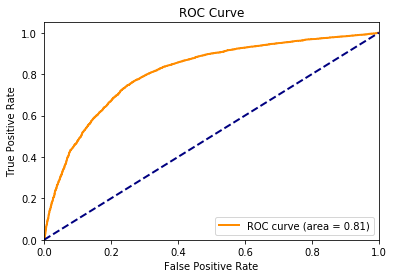

Iter 21150, Minibatch Loss= 0.663087, Training Accuracy= 0.66667
Iter 21300, Minibatch Loss= 0.616268, Training Accuracy= 0.86667
Iter 21450, Minibatch Loss= 0.610461, Training Accuracy= 0.73333
Iter 21600, Minibatch Loss= 0.411541, Training Accuracy= 0.86667
Iter 21750, Minibatch Loss= 0.670051, Training Accuracy= 0.53333
Validation Accuracy: 0.72031987
Validation Loss: 0.56305915
Iter 21900, Minibatch Loss= 0.414721, Training Accuracy= 0.86667
Iter 22050, Minibatch Loss= 0.493952, Training Accuracy= 0.73333
Iter 22200, Minibatch Loss= 0.543624, Training Accuracy= 0.66667
Iter 22350, Minibatch Loss= 0.397370, Training Accuracy= 0.86667
Iter 22500, Minibatch Loss= 0.504574, Training Accuracy= 0.80000
Validation Accuracy: 0.7269598
Validation Loss: 0.56100035
Iter 22650, Minibatch Loss= 0.467584, Training Accuracy= 0.93333
Iter 22800, Minibatch Loss= 0.523479, Training Accuracy= 0.80000
Iter 22950, Minibatch Loss= 0.716081, Training Accuracy= 0.60000
Iter 23100, Minibatch Loss= 0.544136

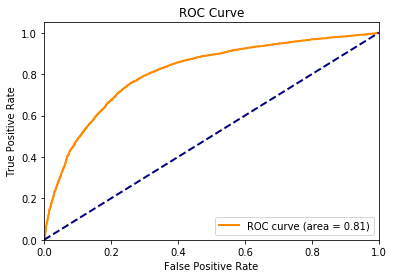

Iter 25650, Minibatch Loss= 0.616517, Training Accuracy= 0.66667
Iter 25800, Minibatch Loss= 0.406039, Training Accuracy= 0.80000
Iter 25950, Minibatch Loss= 0.686801, Training Accuracy= 0.60000
Iter 26100, Minibatch Loss= 0.619158, Training Accuracy= 0.66667
Iter 26250, Minibatch Loss= 0.519394, Training Accuracy= 0.66667
Validation Accuracy: 0.70975995
Validation Loss: 0.5735629
Iter 26400, Minibatch Loss= 0.772485, Training Accuracy= 0.53333
Iter 26550, Minibatch Loss= 0.508789, Training Accuracy= 0.80000
Iter 26700, Minibatch Loss= 0.436411, Training Accuracy= 0.80000
Iter 26850, Minibatch Loss= 0.801092, Training Accuracy= 0.53333
Iter 27000, Minibatch Loss= 0.473064, Training Accuracy= 0.80000
Validation Accuracy: 0.7314398
Validation Loss: 0.58060116
Iter 27150, Minibatch Loss= 0.375713, Training Accuracy= 0.86667
Iter 27300, Minibatch Loss= 0.864595, Training Accuracy= 0.53333
Iter 27450, Minibatch Loss= 0.526725, Training Accuracy= 0.73333
Iter 27600, Minibatch Loss= 0.946589,

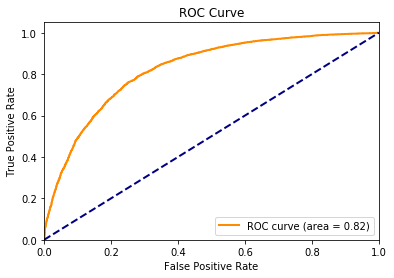

Iter 39150, Minibatch Loss= 0.479399, Training Accuracy= 0.80000
Iter 39300, Minibatch Loss= 0.608038, Training Accuracy= 0.73333
Iter 39450, Minibatch Loss= 0.282065, Training Accuracy= 0.93333
Iter 39600, Minibatch Loss= 0.356064, Training Accuracy= 0.86667
Iter 39750, Minibatch Loss= 0.453564, Training Accuracy= 0.80000
Validation Accuracy: 0.73791987
Validation Loss: 0.53921634
Iter 39900, Minibatch Loss= 0.491134, Training Accuracy= 0.86667
Iter 40050, Minibatch Loss= 0.610175, Training Accuracy= 0.60000
Iter 40200, Minibatch Loss= 0.565937, Training Accuracy= 0.80000
Iter 40350, Minibatch Loss= 0.467330, Training Accuracy= 0.80000
Iter 40500, Minibatch Loss= 0.641271, Training Accuracy= 0.66667
Validation Accuracy: 0.74759984
Validation Loss: 0.53261405
Iter 40650, Minibatch Loss= 0.643276, Training Accuracy= 0.66667
Iter 40800, Minibatch Loss= 0.495274, Training Accuracy= 0.80000
Iter 40950, Minibatch Loss= 0.723192, Training Accuracy= 0.66667
Iter 41100, Minibatch Loss= 0.45477

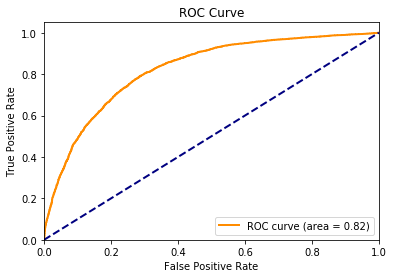

Iter 47400, Minibatch Loss= 0.539722, Training Accuracy= 0.73333
Iter 47550, Minibatch Loss= 0.275588, Training Accuracy= 0.93333
Iter 47700, Minibatch Loss= 0.452409, Training Accuracy= 0.86667
Iter 47850, Minibatch Loss= 0.321151, Training Accuracy= 0.93333
Iter 48000, Minibatch Loss= 0.455259, Training Accuracy= 0.80000
Validation Accuracy: 0.74439985
Validation Loss: 0.5282525
Iter 48150, Minibatch Loss= 0.369283, Training Accuracy= 0.86667
Iter 48300, Minibatch Loss= 0.460028, Training Accuracy= 0.80000
Iter 48450, Minibatch Loss= 0.748674, Training Accuracy= 0.60000
Iter 48600, Minibatch Loss= 0.634721, Training Accuracy= 0.66667
Iter 48750, Minibatch Loss= 0.410211, Training Accuracy= 0.80000
Validation Accuracy: 0.7242398
Validation Loss: 0.5549922
Iter 48900, Minibatch Loss= 0.394947, Training Accuracy= 0.93333
Iter 49050, Minibatch Loss= 0.894739, Training Accuracy= 0.60000
Iter 49200, Minibatch Loss= 0.391068, Training Accuracy= 0.86667
Iter 49350, Minibatch Loss= 0.526986, 

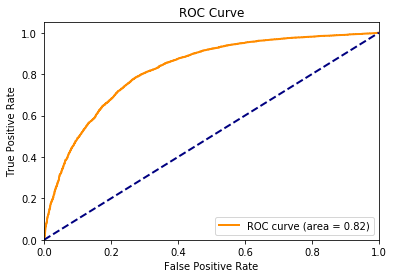

Iter 58650, Minibatch Loss= 0.597482, Training Accuracy= 0.73333
Iter 58800, Minibatch Loss= 0.525572, Training Accuracy= 0.86667
Iter 58950, Minibatch Loss= 0.572130, Training Accuracy= 0.73333
Iter 59100, Minibatch Loss= 0.380841, Training Accuracy= 0.86667
Iter 59250, Minibatch Loss= 0.628775, Training Accuracy= 0.66667
Validation Accuracy: 0.7388798
Validation Loss: 0.5405768
Iter 59400, Minibatch Loss= 0.367988, Training Accuracy= 0.93333
Iter 59550, Minibatch Loss= 0.517392, Training Accuracy= 0.73333
Iter 59700, Minibatch Loss= 0.534178, Training Accuracy= 0.66667
Iter 59850, Minibatch Loss= 0.357522, Training Accuracy= 0.86667
Iter 60000, Minibatch Loss= 0.529111, Training Accuracy= 0.73333
Validation Accuracy: 0.7529598
Validation Loss: 0.5407235
Iter 60150, Minibatch Loss= 0.379190, Training Accuracy= 0.86667
Iter 60300, Minibatch Loss= 0.469334, Training Accuracy= 0.86667
Iter 60450, Minibatch Loss= 0.593772, Training Accuracy= 0.66667
Iter 60600, Minibatch Loss= 0.465311, T

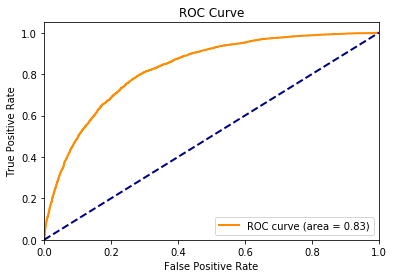

Iter 100650, Minibatch Loss= 0.726826, Training Accuracy= 0.60000
Iter 100800, Minibatch Loss= 0.279951, Training Accuracy= 0.93333
Iter 100950, Minibatch Loss= 0.688126, Training Accuracy= 0.60000
Iter 101100, Minibatch Loss= 0.443297, Training Accuracy= 0.86667
Iter 101250, Minibatch Loss= 0.427178, Training Accuracy= 0.86667
Validation Accuracy: 0.74047977
Validation Loss: 0.5309157
Iter 101400, Minibatch Loss= 0.614683, Training Accuracy= 0.60000
Iter 101550, Minibatch Loss= 0.575133, Training Accuracy= 0.73333
Iter 101700, Minibatch Loss= 0.511716, Training Accuracy= 0.86667
Iter 101850, Minibatch Loss= 0.795609, Training Accuracy= 0.53333
Iter 102000, Minibatch Loss= 0.475975, Training Accuracy= 0.80000
Validation Accuracy: 0.74471986
Validation Loss: 0.5418291
Iter 102150, Minibatch Loss= 0.289338, Training Accuracy= 0.86667
Iter 102300, Minibatch Loss= 0.872257, Training Accuracy= 0.60000
Iter 102450, Minibatch Loss= 0.456650, Training Accuracy= 0.80000
Iter 102600, Minibatch L

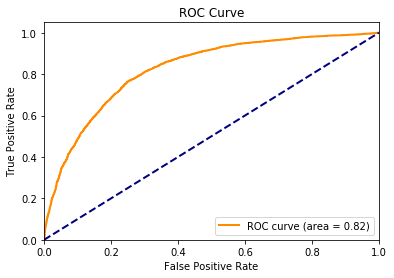

Iter 103650, Minibatch Loss= 0.523598, Training Accuracy= 0.73333
Iter 103800, Minibatch Loss= 0.406516, Training Accuracy= 0.93333
Iter 103950, Minibatch Loss= 0.527572, Training Accuracy= 0.73333
Iter 104100, Minibatch Loss= 0.684011, Training Accuracy= 0.66667
Iter 104250, Minibatch Loss= 0.366182, Training Accuracy= 0.93333
Validation Accuracy: 0.7525599
Validation Loss: 0.5184218
Iter 104400, Minibatch Loss= 0.396189, Training Accuracy= 0.93333
Iter 104550, Minibatch Loss= 0.665054, Training Accuracy= 0.66667
Iter 104700, Minibatch Loss= 0.465160, Training Accuracy= 0.80000
Iter 104850, Minibatch Loss= 0.252492, Training Accuracy= 0.93333
Iter 105000, Minibatch Loss= 0.442400, Training Accuracy= 0.80000
Validation Accuracy: 0.75623983
Validation Loss: 0.51890445


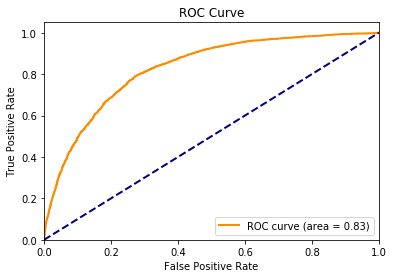

Iter 105150, Minibatch Loss= 0.585126, Training Accuracy= 0.73333
Iter 105300, Minibatch Loss= 0.528420, Training Accuracy= 0.73333
Iter 105450, Minibatch Loss= 0.750778, Training Accuracy= 0.60000
Iter 105600, Minibatch Loss= 0.544537, Training Accuracy= 0.80000
Iter 105750, Minibatch Loss= 0.340821, Training Accuracy= 0.86667
Validation Accuracy: 0.75615984
Validation Loss: 0.5160873
Iter 105900, Minibatch Loss= 0.406961, Training Accuracy= 0.80000
Iter 106050, Minibatch Loss= 0.489286, Training Accuracy= 0.86667
Iter 106200, Minibatch Loss= 0.493363, Training Accuracy= 0.80000
Iter 106350, Minibatch Loss= 0.655873, Training Accuracy= 0.66667
Iter 106500, Minibatch Loss= 0.280427, Training Accuracy= 0.93333
Validation Accuracy: 0.73447984
Validation Loss: 0.55876553
Iter 106650, Minibatch Loss= 0.362754, Training Accuracy= 0.80000
Iter 106800, Minibatch Loss= 0.553307, Training Accuracy= 0.73333
Iter 106950, Minibatch Loss= 0.547082, Training Accuracy= 0.66667
Iter 107100, Minibatch 

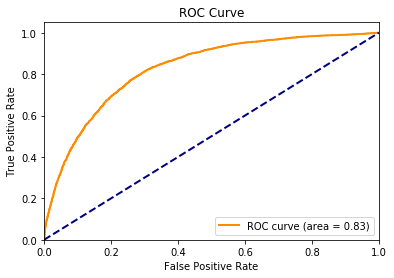

Iter 137400, Minibatch Loss= 0.484751, Training Accuracy= 0.73333
Iter 137550, Minibatch Loss= 0.495660, Training Accuracy= 0.80000
Iter 137700, Minibatch Loss= 0.560842, Training Accuracy= 0.73333
Iter 137850, Minibatch Loss= 0.535579, Training Accuracy= 0.80000
Iter 138000, Minibatch Loss= 0.380297, Training Accuracy= 0.86667
Validation Accuracy: 0.75391984
Validation Loss: 0.5131395
Iter 138150, Minibatch Loss= 0.637595, Training Accuracy= 0.53333
Iter 138300, Minibatch Loss= 0.393083, Training Accuracy= 0.86667
Iter 138450, Minibatch Loss= 0.657427, Training Accuracy= 0.66667
Iter 138600, Minibatch Loss= 0.443096, Training Accuracy= 0.86667
Iter 138750, Minibatch Loss= 0.389466, Training Accuracy= 0.86667
Validation Accuracy: 0.7560798
Validation Loss: 0.5228379
Iter 138900, Minibatch Loss= 0.602244, Training Accuracy= 0.60000
Iter 139050, Minibatch Loss= 0.586765, Training Accuracy= 0.80000
Iter 139200, Minibatch Loss= 0.477255, Training Accuracy= 0.86667
Iter 139350, Minibatch Lo

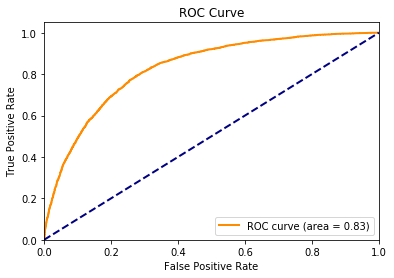

Iter 141900, Minibatch Loss= 0.263267, Training Accuracy= 0.93333
Iter 142050, Minibatch Loss= 0.593579, Training Accuracy= 0.66667
Iter 142200, Minibatch Loss= 0.438343, Training Accuracy= 0.80000
Iter 142350, Minibatch Loss= 0.261347, Training Accuracy= 1.00000
Iter 142500, Minibatch Loss= 0.438743, Training Accuracy= 0.73333
Validation Accuracy: 0.7531198
Validation Loss: 0.52752775
Iter 142650, Minibatch Loss= 0.486091, Training Accuracy= 0.73333
Iter 142800, Minibatch Loss= 0.507737, Training Accuracy= 0.73333
Iter 142950, Minibatch Loss= 0.767443, Training Accuracy= 0.66667
Iter 143100, Minibatch Loss= 0.538055, Training Accuracy= 0.80000
Iter 143250, Minibatch Loss= 0.336305, Training Accuracy= 0.86667
Validation Accuracy: 0.7567198
Validation Loss: 0.5157873
Iter 143400, Minibatch Loss= 0.422248, Training Accuracy= 0.80000
Iter 143550, Minibatch Loss= 0.468825, Training Accuracy= 0.86667
Iter 143700, Minibatch Loss= 0.502355, Training Accuracy= 0.73333
Iter 143850, Minibatch Lo

In [18]:
%%time

best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))